# Intervention

In [86]:
import pandas as pd
import secrets

ASINS = [secrets.token_hex(5).upper() for i in range(1000)]
import numpy as np
def buying_data(alpha, beta, demand_mean): #alpha - 1 or 0 - confirmed or not, beta - 1 or 0, deamnd_mean - mean of gamma distribution 
    constraint = np.random.gamma(1, scale=1, size=1000) 
    demand = np.random.gamma(demand_mean, scale=1, size=1000) 
    submitted = demand  - constraint + np.random.gamma(1, scale=1, size=1000) 
    confirmed = alpha * submitted + np.random.gamma(0.1, scale=1, size=1000)
    tr= 0.5 * confirmed + np.random.gamma(1, scale=1, size =1000)
    received = beta * confirmed + np.random.gamma(0.1, scale=1, size=1000) - tr
    
    return pd.DataFrame(dict(asin=ASINS,
                              demand=np.round(demand),
                              constraint=np.round(constraint),
                              submitted = np.round(submitted),
                              confirmed = np.round(confirmed),
                              tr=np.round(tr),
                              received = np.round(received)
                             ))


# we change the parameters alpha and demand_mean between weeks
data_week1 = buying_data(1, 1, demand_mean=2)
data_week1['week'] = 'w1'
data_week2 = buying_data(2, 1, demand_mean=4)
data_week2['week'] = 'w2'

data = pd.concat([data_week1, data_week2], ignore_index=True)
# write data to a csv file
data.to_csv('supply_chain_week_over_week2.csv', index=False)

In [87]:
import pandas as pd

data = pd.read_csv('supply_chain_week_over_week2.csv')

In [88]:
print(data)

            asin  demand  constraint  submitted  confirmed   tr  received week
0     EB34C1AD1A     0.0         1.0       -1.0        0.0  0.0      -0.0   w1
1     1FEBC9808F     2.0         4.0       -1.0       -1.0  2.0      -3.0   w1
2     43AE3A942F     3.0         1.0        6.0        6.0  3.0       3.0   w1
3     37C7E58D69     1.0         1.0        1.0        1.0  1.0       0.0   w1
4     5A9660A4F3     1.0         0.0        1.0        1.0  2.0      -1.0   w1
...          ...     ...         ...        ...        ...  ...       ...  ...
1995  40C09BC5E1     3.0         2.0        1.0        2.0  3.0      -2.0   w2
1996  0687DE111B     7.0         0.0        6.0       13.0  8.0       5.0   w2
1997  6A1B7ED5BD     3.0         2.0        2.0        4.0  2.0       2.0   w2
1998  2F7A7638A9     4.0         1.0        4.0        8.0  6.0       2.0   w2
1999  DABB3DF121     5.0         3.0        5.0       10.0  5.0       5.0   w2

[2000 rows x 8 columns]


In [89]:
from IPython.display import HTML

data_week1 = data[data.week == 'w1']

HTML(data_week1.head().to_html(index=False)+'<br/>')

asin,demand,constraint,submitted,confirmed,tr,received,week
EB34C1AD1A,0.0,1.0,-1.0,0.0,0.0,-0.0,w1
1FEBC9808F,2.0,4.0,-1.0,-1.0,2.0,-3.0,w1
43AE3A942F,3.0,1.0,6.0,6.0,3.0,3.0,w1
37C7E58D69,1.0,1.0,1.0,1.0,1.0,0.0,w1
5A9660A4F3,1.0,0.0,1.0,1.0,2.0,-1.0,w1


In [90]:
data_week2 = data[data.week=='w2']

HTML(data_week2.head().to_html(index=False)+'<br/>')

asin,demand,constraint,submitted,confirmed,tr,received,week
EB34C1AD1A,7.0,0.0,8.0,16.0,10.0,6.0,w2
1FEBC9808F,10.0,2.0,8.0,16.0,9.0,7.0,w2
43AE3A942F,4.0,0.0,6.0,12.0,7.0,5.0,w2
37C7E58D69,9.0,0.0,9.0,19.0,11.0,8.0,w2
5A9660A4F3,2.0,0.0,2.0,4.0,2.0,2.0,w2


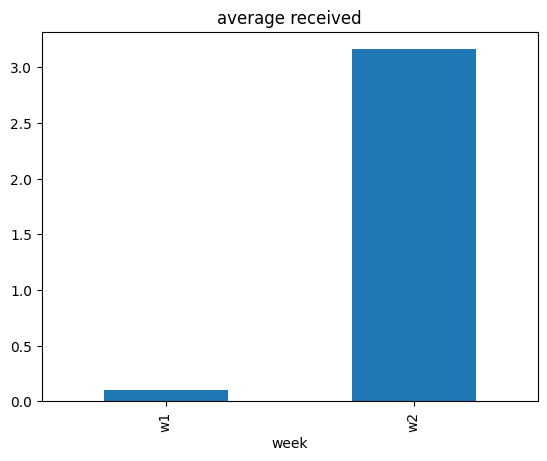

In [91]:
data.groupby(['week']).mean(numeric_only=True)[['received']].plot(kind='bar', title='average received', legend=False);

In [92]:
data_week2.received.mean() - data_week1.received.mean()

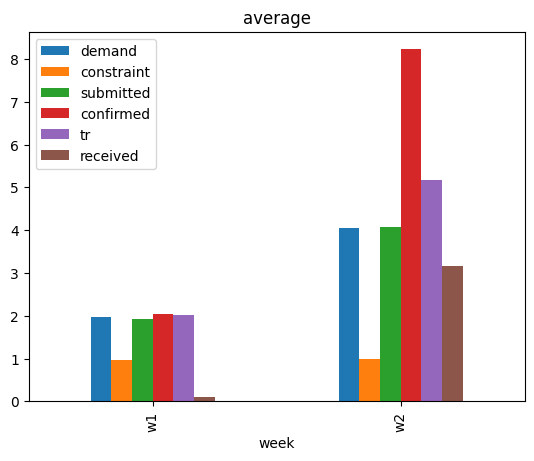

In [93]:
data.groupby(['week']).mean(numeric_only=True).plot(kind='bar', title='average', legend=True);

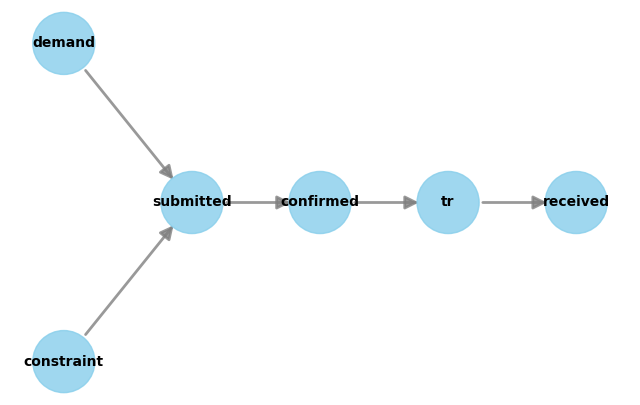

In [94]:
import networkx as nx
import dowhy.gcm as gcm #gcm - graphical causal model 
from dowhy.utils import plot

causal_graph = nx.DiGraph([('demand', 'submitted'),
                           ('constraint', 'submitted'),
                           ('submitted', 'confirmed'),
                           ('confirmed', 'tr'),
                           ('tr', 'received')])
plot(causal_graph)

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# disabling progress bar to not clutter the output here
gcm.config.disable_progress_bars()

# setting random seed for reproducibility
np.random.seed(10)

causal_model = gcm.StructuralCausalModel(causal_graph)

# Automatically assign appropriate causal models to each node in graph
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data_week1)

In [96]:
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

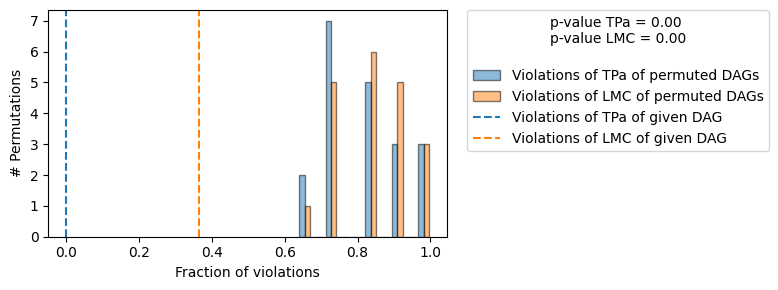

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 20 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 4/11 LMCs and is better than 100.0% of the permuted DAGs (p-value: 0.00).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+

In [97]:
gcm.falsify.falsify_graph(causal_graph, data_week1, n_permutations=20, plot_histogram=True) #Validates the DAG using Data - week1 

In [98]:
# call the API for attributing change in the average value of `received`
# the distribution change from week1 to week2 based on "received"
#distributio_change identifies other variables causing the change
contributions = gcm.distribution_change(causal_model,
                                        data_week1,
                                        data_week2,
                                        'received',
                                        num_samples=2000,
                                        difference_estimation_func=lambda x1, x2 : np.mean(x2) - np.mean(x1)) #x1 - week 1 received, x2- week2 received

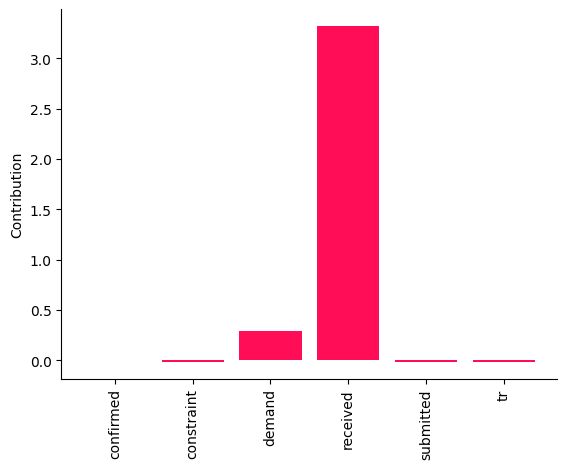

In [99]:
from dowhy.utils import bar_plot
bar_plot(contributions, ylabel='Contribution')

In [100]:
median_contribs, uncertainty_contribs = gcm.confidence_intervals(
    gcm.bootstrap_sampling(gcm.distribution_change,
                           causal_model,
                           data_week1,
                           data_week2,
                           'received',
                           num_samples=2000,
                           difference_estimation_func=lambda x1, x2 : np.mean(x2) - np.mean(x1)),
    confidence_level=0.95,
    num_bootstrap_resamples=5,
    n_jobs=-1)

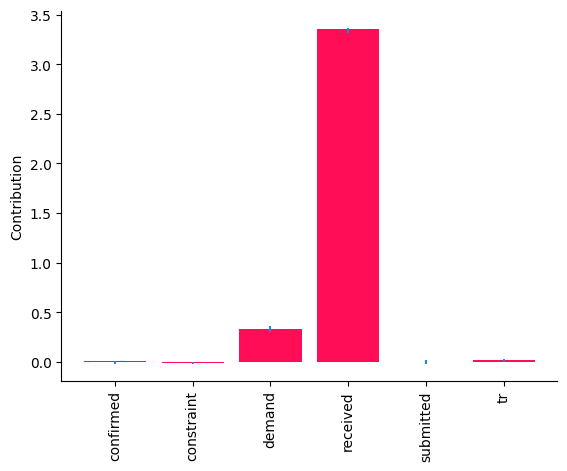

In [101]:
bar_plot(median_contribs, ylabel='Contribution', uncertainties=uncertainty_contribs)

#u_confirmed

In [111]:
import pandas as pd
import secrets

ASINS = [secrets.token_hex(5).upper() for i in range(1000)]
import numpy as np
def buying_data(alpha, beta, demand_mean): #alpha - 1 or 0 - confirmed or not, beta - 1 or 0, deamnd_mean - mean of gamma distribution 
    constraint = np.random.gamma(1, scale=1, size=1000) 
    demand = np.random.gamma(demand_mean, scale=1, size=1000) 
    submitted = demand  - constraint + np.random.gamma(1, scale=1, size=1000) 
    confirmed = alpha * submitted + np.random.gamma(0.1, scale=1, size=1000)
    tr= 0.5 * confirmed + np.random.gamma(1, scale=1, size =1000)
    u_confirmed = confirmed - tr
    received = beta * u_confirmed + np.random.gamma(0.1, scale=1, size=1000) 
    
    return pd.DataFrame(dict(asin=ASINS,
                              demand=np.round(demand),
                              constraint=np.round(constraint),
                              submitted = np.round(submitted),
                              confirmed = np.round(confirmed),
                              tr=np.round(tr),
                              u_confirmed=np.round(u_confirmed),
                              received = np.round(received)
                             ))


# we change the parameters alpha and demand_mean between weeks
data_week1 = buying_data(1, 1, demand_mean=2)
data_week1['week'] = 'w1'
data_week2 = buying_data(2, 1, demand_mean=4)
data_week2['week'] = 'w2'

data = pd.concat([data_week1, data_week2], ignore_index=True)
# write data to a csv file
data.to_csv('supply_chain_week_over_week3.csv', index=False)

In [112]:
import pandas as pd

data = pd.read_csv('supply_chain_week_over_week3.csv')
print(data)

            asin  demand  constraint  submitted  confirmed   tr  u_confirmed  \
0     16C7FFAB1E     2.0         0.0        1.0        1.0  3.0         -1.0   
1     D8DF5B499C     0.0         2.0       -2.0       -1.0  0.0         -2.0   
2     4947BA5431     3.0         1.0        3.0        3.0  2.0          1.0   
3     307C702C70     4.0         1.0        3.0        3.0  4.0         -1.0   
4     85F7B7B5F4     1.0         0.0        1.0        1.0  2.0         -1.0   
...          ...     ...         ...        ...        ...  ...          ...   
1995  280DDC7F85     8.0         0.0        8.0       17.0  9.0          8.0   
1996  8118CD34D3     7.0         0.0        8.0       16.0  9.0          7.0   
1997  E744F8FAC5     1.0         1.0       -0.0       -0.0  0.0         -0.0   
1998  98E989FBBC     4.0         1.0        3.0        6.0  4.0          3.0   
1999  7F3C127E07     3.0         1.0        4.0        9.0  5.0          4.0   

      received week  
0         -1.0   

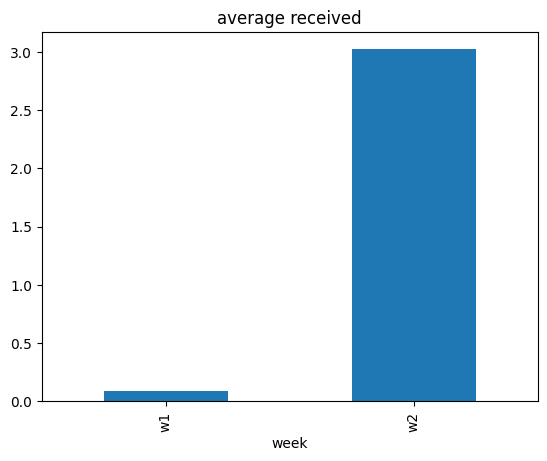

In [113]:
data.groupby(['week']).mean(numeric_only=True)[['received']].plot(kind='bar', title='average received', legend=False);

In [114]:
data_week2.received.mean() - data_week1.received.mean()

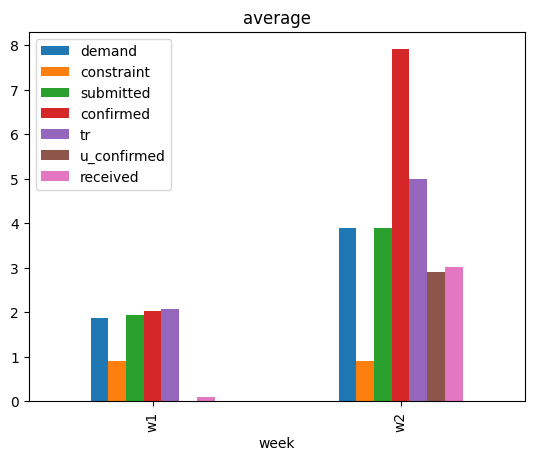

In [115]:
data.groupby(['week']).mean(numeric_only=True).plot(kind='bar', title='average', legend=True);

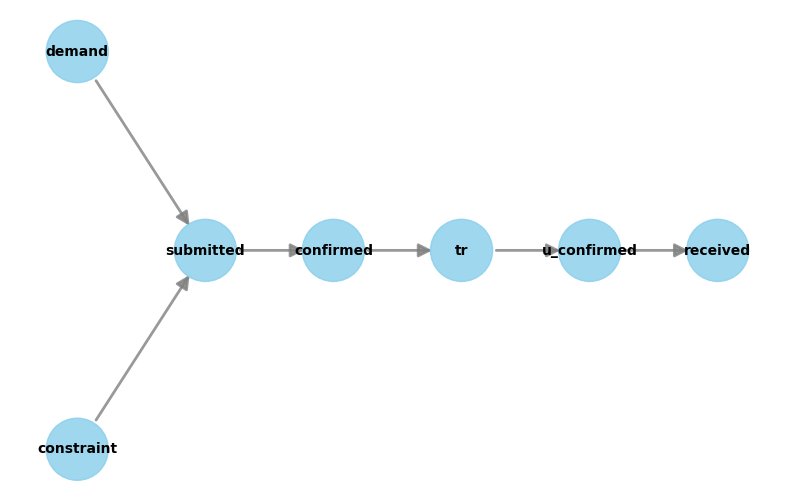

In [126]:
import networkx as nx
import dowhy.gcm as gcm #gcm - graphical causal model 
from dowhy.utils import plot

causal_graph = nx.DiGraph([('demand', 'submitted'),
                           ('constraint', 'submitted'),
                           ('submitted', 'confirmed'),
                           ('confirmed', 'tr'),
                           ('tr', 'u_confirmed'),
                           ('u_confirmed', 'received')])
plot(causal_graph)

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# disabling progress bar to not clutter the output here
gcm.config.disable_progress_bars()

# setting random seed for reproducibility
np.random.seed(10)

causal_model = gcm.StructuralCausalModel(causal_graph)

# Automatically assign appropriate causal models to each node in graph
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data_week1)

In [119]:
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

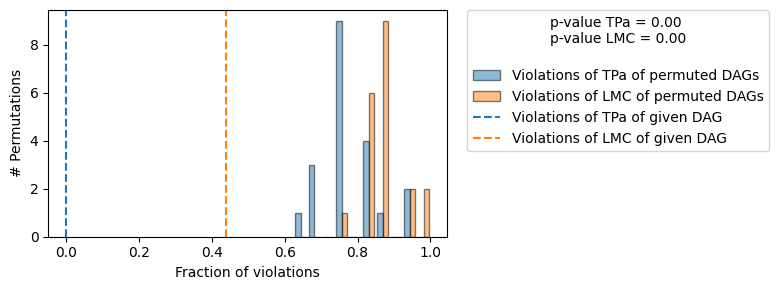

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 20 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 7/16 LMCs and is better than 100.0% of the permuted DAGs (p-value: 0.00).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+

In [128]:
gcm.falsify.falsify_graph(causal_graph, data_week1, n_permutations=20, plot_histogram=True) #Validates the DAG using Data - week1 

In [120]:
# call the API for attributing change in the average value of `received`
# the distribution change from week1 to week2 based on "received"
#distributio_change identifies other variables causing the change
contributions = gcm.distribution_change(causal_model,
                                        data_week1,
                                        data_week2,
                                        'received',
                                        num_samples=2000,
                                        difference_estimation_func=lambda x1, x2 : np.mean(x2) - np.mean(x1)) #x1 - week 1 received, x2- week2 received

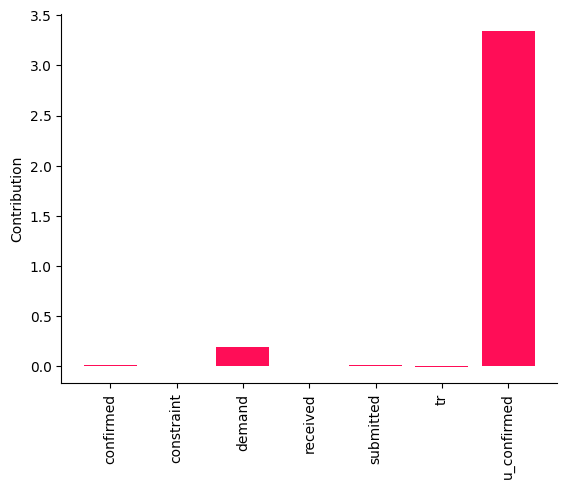

In [121]:
from dowhy.utils import bar_plot
bar_plot(contributions, ylabel='Contribution')

In [122]:
median_contribs, uncertainty_contribs = gcm.confidence_intervals(
    gcm.bootstrap_sampling(gcm.distribution_change,
                           causal_model,
                           data_week1,
                           data_week2,
                           'received',
                           num_samples=2000,
                           difference_estimation_func=lambda x1, x2 : np.mean(x2) - np.mean(x1)),
    confidence_level=0.95,
    num_bootstrap_resamples=5,
    n_jobs=-1)

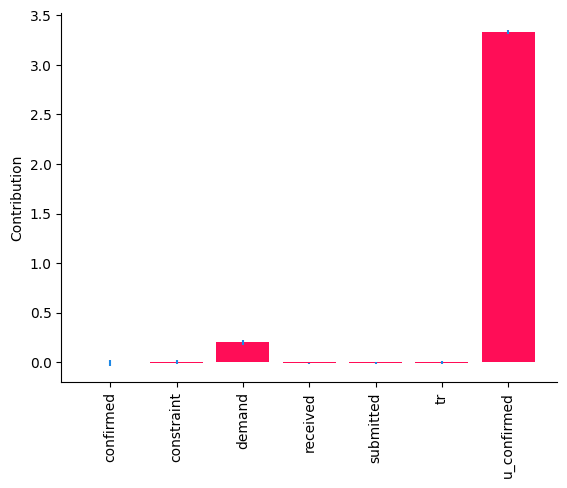

In [123]:
bar_plot(median_contribs, ylabel='Contribution', uncertainties=uncertainty_contribs)

submitted

In [135]:
# call the API for attributing change in the average value of `received`
# the distribution change from week1 to week2 based on "received"
#distributio_change identifies other variables causing the change
contributions = gcm.distribution_change(causal_model,
                                        data_week1,
                                        data_week2,
                                        'submitted',
                                        num_samples=2000,
                                        difference_estimation_func=lambda x1, x2 : np.mean(x2) - np.mean(x1)) #x1 - week 1 received, x2- week2 received

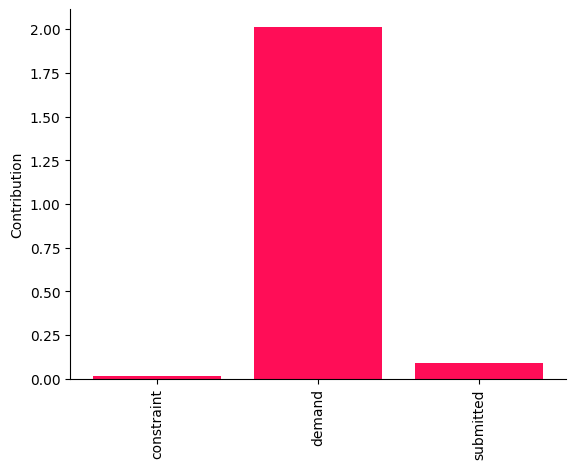

In [136]:
from dowhy.utils import bar_plot
bar_plot(contributions, ylabel='Contribution')

In [137]:
median_contribs, uncertainty_contribs = gcm.confidence_intervals(
    gcm.bootstrap_sampling(gcm.distribution_change,
                           causal_model,
                           data_week1,
                           data_week2,
                           'submitted',
                           num_samples=2000,
                           difference_estimation_func=lambda x1, x2 : np.mean(x2) - np.mean(x1)),
    confidence_level=0.95,
    num_bootstrap_resamples=5,
    n_jobs=-1)

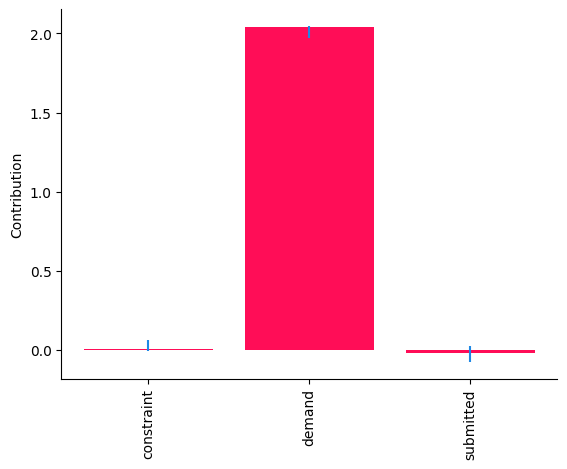

In [138]:
bar_plot(median_contribs, ylabel='Contribution', uncertainties=uncertainty_contribs)

Effect Estimation

In [102]:
from dowhy import CausalModel
from IPython.display import Image, display

In [103]:
#Creating the 
causal_graph1 = """
digraph {
demand; 
submitted;
constraint; 
confirmed;
received;
tr;
U[label="Unobserved Confounders"];
demand -> submitted; constraint -> submitted; 
submitted -> confirmed; U->confirmed; U-> tr; U-> received; confirmed -> tr; confirmed -> received;
tr ->received;
}
"""

c:\Users\CB.EN.U4CSE20614\AppData\Local\Programs\Python\Python311\Lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


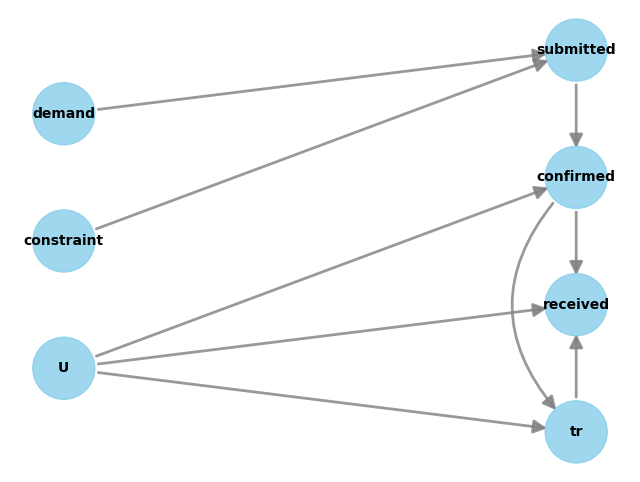

In [104]:
model= CausalModel(
        data = data_week1,
        graph=causal_graph1.replace("\n", " "),
        treatment='received',
        outcome='tr')
model.view_model()
#display(Image(filename="causal_model.png"))